In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2023-11-08 14:16:33.872577: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 14:16:33.899880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 14:16:33.899906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 14:16:33.899924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 14:16:33.904900: I tensorflow/core/platform/cpu_feature_g

In [2]:
file_path = 'data/PLTR_diff.csv'
target_column_name = 'Close Diff'

pltr = pd.read_csv(file_path, index_col=0, parse_dates=True)
pltr.dropna(inplace=True)

pltr.shape

(2315, 22)

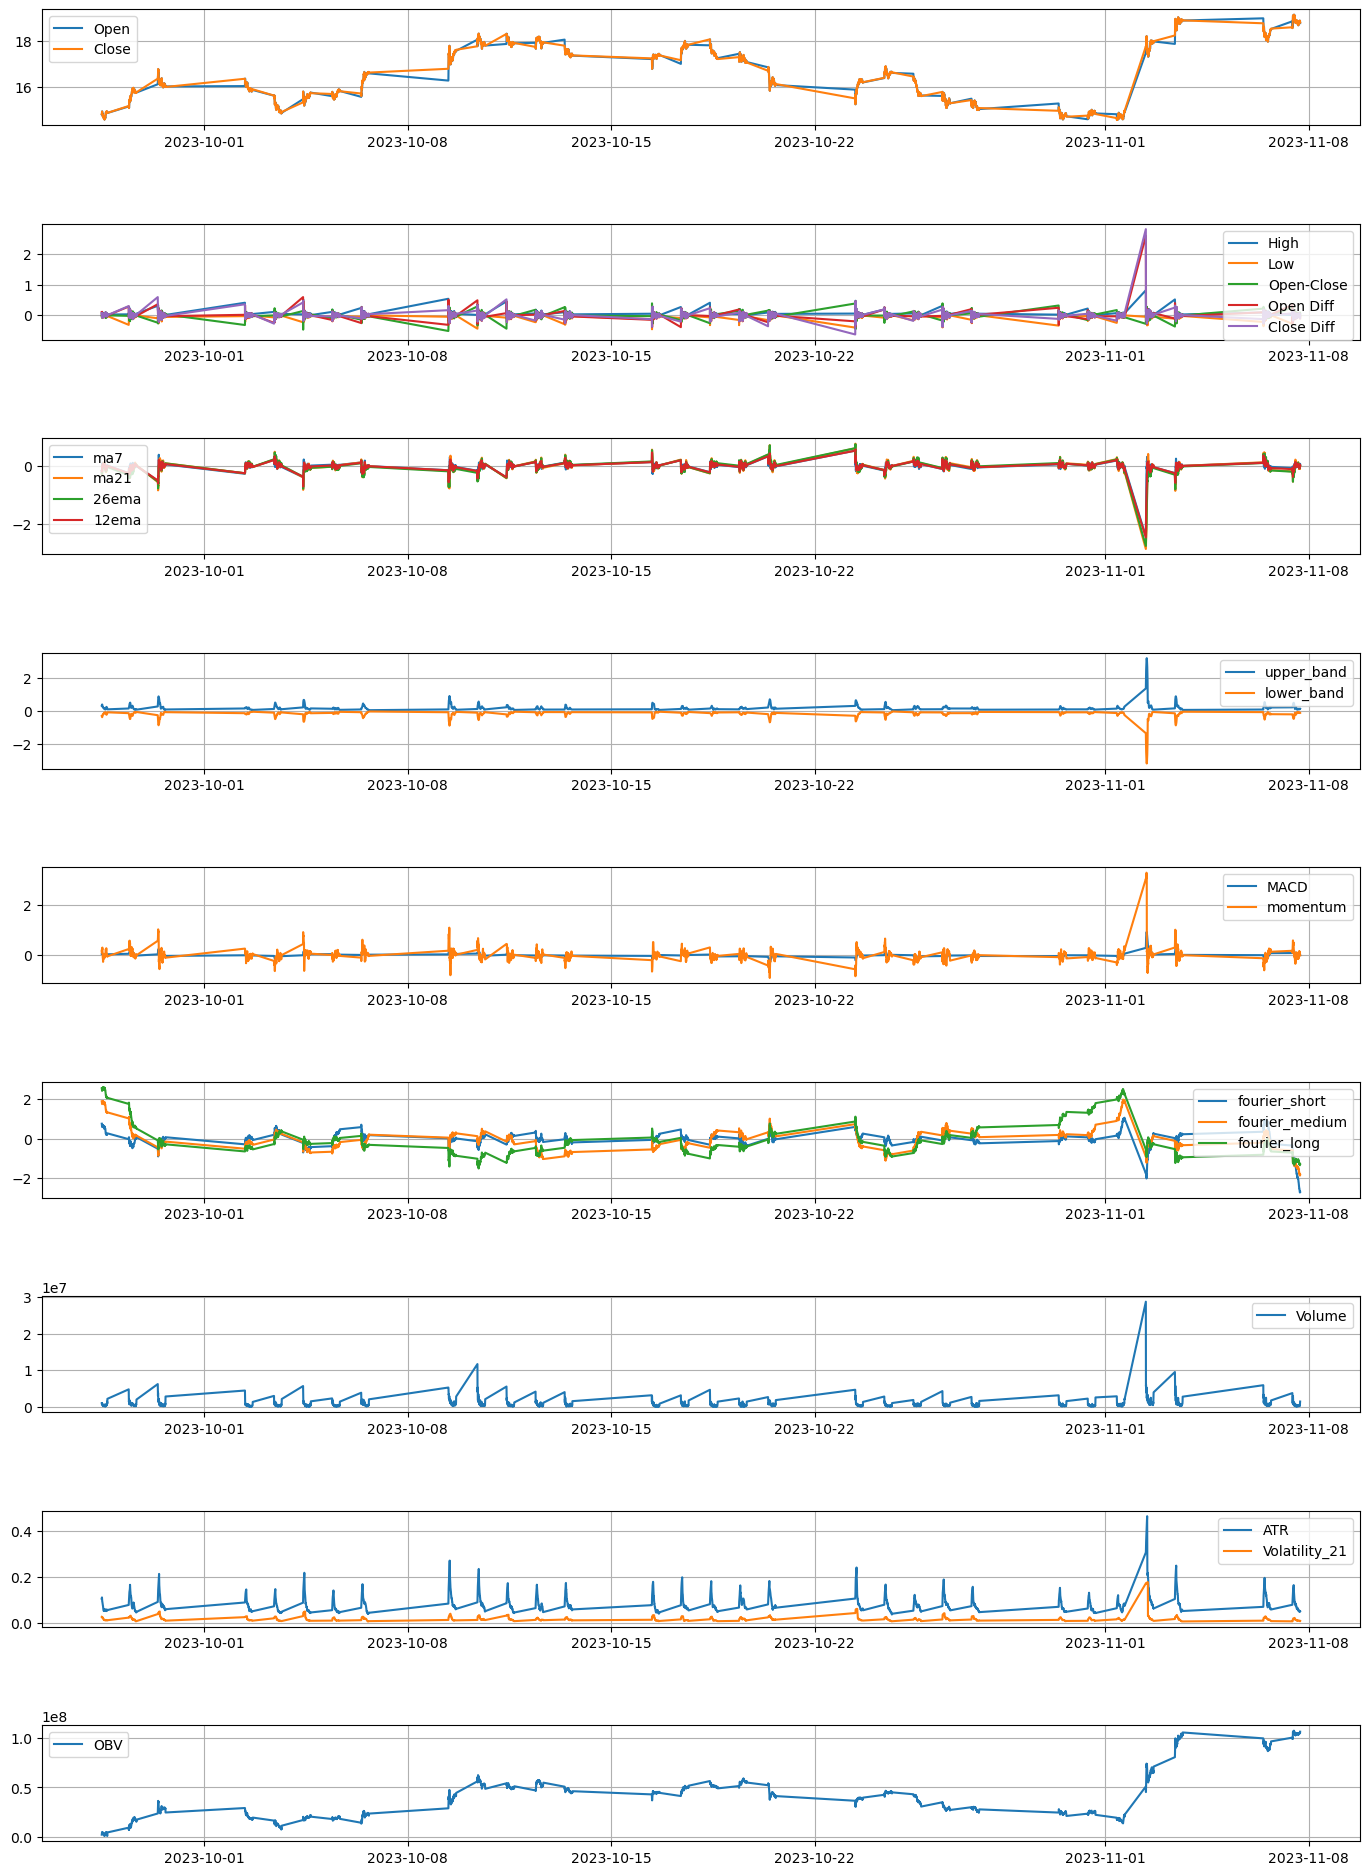

In [3]:
plotting_groups = [
    ['Open', 'Close'],
    ['High', 'Low', 'Open-Close', 'Open Diff', 'Close Diff'], # price_related
    ['ma7', 'ma21', '26ema', '12ema'], # moving_averages,
    ['upper_band', 'lower_band'], # bands_volatility,
    ['MACD', 'momentum'], # trading_indicators,
    ['fourier_short', 'fourier_medium', 'fourier_long'], # fourier_transforms,
    ['Volume'], # volume_changes
    ['ATR', 'Volatility_21'],
    ['OBV']
]

fig, axes = plt.subplots(nrows=len(plotting_groups), ncols=1, figsize=(15, 20), squeeze=False)
fig.tight_layout(pad=5.0)

for ax_array, group in zip(axes, plotting_groups):
    ax = ax_array[0]
    for col in group:
        ax.plot(pltr.index.to_numpy(), pltr[col].to_numpy(), label=col)
    ax.legend()
    ax.grid(True)

plt.show()

In [4]:
cols = [target_column_name] + [ col for col in pltr if col != target_column_name]
target_column = list(pltr.columns).index(target_column_name)
data = pltr[cols]

# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

# Split the data
train_size = int(len(data_array) * 0.80)

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i])
    return np.array(sequence_data), np.array(sequence_target)

SEQUENCE_LENGTH = 17
data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

train_data, test_data = data_sequences[:train_size], data_sequences[train_size:]
train_target, test_target = target_sequences[:train_size], target_sequences[train_size:]

In [ ]:
test_index = -1
a = scaler_data.inverse_transform(data_sequences[test_index])
b = scaler_target.inverse_transform(target_sequences)

print(f"Values for the [{test_index}] prediction:")
for i in range (0, 17):
    print(f"\tdata[{i}]: {a[i][0]}")

print(f'\n\tprediction: {b[test_index]}')

# Correct

In [6]:
############################################################################################################
#
# Model Definition
#
############################################################################################################

def build_attention_model():
    """LSTM model"""
    inputs = keras.layers.Input(shape=(train_data.shape[1], train_data.shape[2]))
    lstm_out = keras.layers.LSTM(90, return_sequences=False, return_state=False) (inputs)
    attention = keras.layers.Attention() ([lstm_out, lstm_out])
    context_vector = keras.layers.Concatenate(axis=-1)([lstm_out, attention])
    output = keras.layers.Dense(units=50, activation='relu') (context_vector)
    output = keras.layers.Dense(1, activation='linear') (output)

    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

def train_model(model, train_data, train_target, epochs=30, batch_size=256):
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(  train_data,
                train_target,
                epochs=epochs,
                batch_size=batch_size,
                verbose=2)

model = build_attention_model()

############################################################################################################
#
# Model Generation & Training
#
############################################################################################################
epochs = 900
batch_size = 256

train_model(model, train_data, train_target, epochs=epochs, batch_size=batch_size)

2023-11-08 14:16:55.164053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 14:16:55.194559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 14:16:55.194841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/900


2023-11-08 14:16:57.072515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-08 14:16:57.596078: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564bc73e8580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 14:16:57.596107: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2023-11-08 14:16:57.600379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 14:16:57.661574: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 - 2s - loss: 0.0170 - 2s/epoch - 267ms/step
Epoch 2/900
8/8 - 0s - loss: 0.0026 - 37ms/epoch - 5ms/step
Epoch 3/900
8/8 - 0s - loss: 0.0018 - 37ms/epoch - 5ms/step
Epoch 4/900
8/8 - 0s - loss: 9.4591e-04 - 36ms/epoch - 5ms/step
Epoch 5/900
8/8 - 0s - loss: 6.5367e-04 - 37ms/epoch - 5ms/step
Epoch 6/900
8/8 - 0s - loss: 5.3100e-04 - 35ms/epoch - 4ms/step
Epoch 7/900
8/8 - 0s - loss: 4.7464e-04 - 36ms/epoch - 4ms/step
Epoch 8/900
8/8 - 0s - loss: 4.5599e-04 - 35ms/epoch - 4ms/step
Epoch 9/900
8/8 - 0s - loss: 4.4429e-04 - 35ms/epoch - 4ms/step
Epoch 10/900
8/8 - 0s - loss: 4.4554e-04 - 36ms/epoch - 4ms/step
Epoch 11/900
8/8 - 0s - loss: 4.4435e-04 - 34ms/epoch - 4ms/step
Epoch 12/900
8/8 - 0s - loss: 4.3006e-04 - 35ms/epoch - 4ms/step
Epoch 13/900
8/8 - 0s - loss: 4.2505e-04 - 33ms/epoch - 4ms/step
Epoch 14/900
8/8 - 0s - loss: 4.2747e-04 - 34ms/epoch - 4ms/step
Epoch 15/900
8/8 - 0s - loss: 4.2854e-04 - 34ms/epoch - 4ms/step
Epoch 16/900
8/8 - 0s - loss: 4.2071e-04 - 34ms/epoch - 4m

58/58 [==============================] - 0s 1ms/step


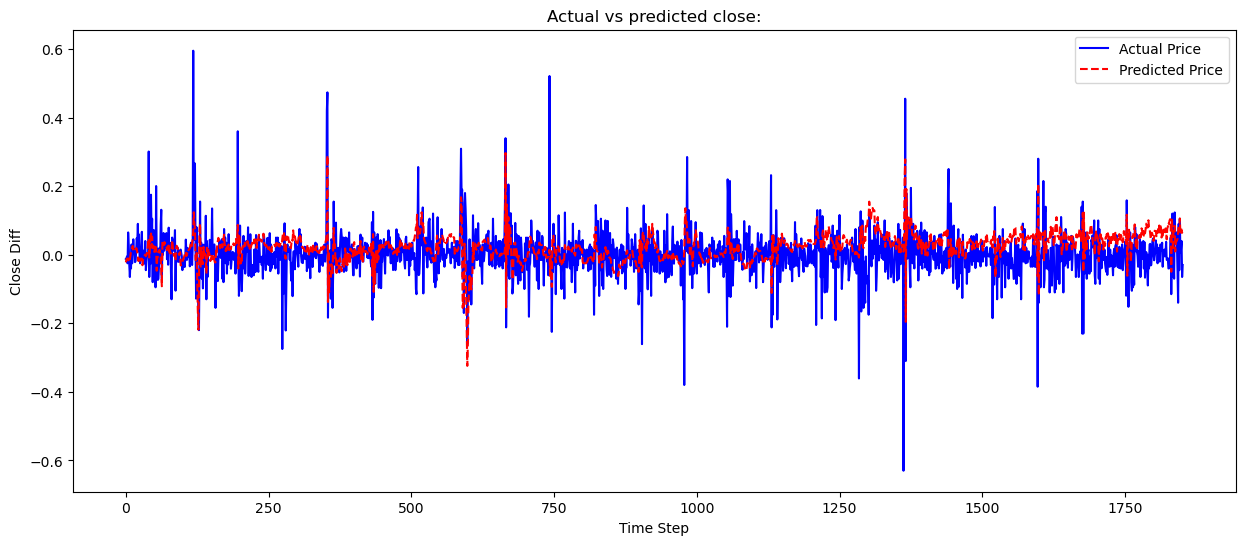

In [8]:
price_predicted_array = scaler_target.inverse_transform(model.predict(train_data))
price_actual_array = scaler_target.inverse_transform(train_target).flatten()

plt.figure(figsize=(15, 6))
plt.plot(price_actual_array, label="Actual Price", color='blue')
plt.plot(price_predicted_array, label="Predicted Price", color='red', linestyle='dashed')
plt.title("Actual vs predicted close:")
plt.xlabel("Time Step")
plt.ylabel(target_column_name)
plt.legend()

plt.show()